# Demo the Phonemizer

In [1]:
import glados.core.phonemizer as phonemizer
import glados.utils.spoken_text_converter as stc

In [2]:
p = phonemizer.Phonemizer()
glados_stc = stc.SpokenTextConverter()

In [ ]:
%%time
input = "Hello CPU, its 3:15 am! if you'll excuse me I'm GLaDOS, not GLadys."
phonemes = p.convert_to_phonemes(input)
print(phonemes)


# Demo the Text-to-Speech module

In [5]:
import sounddevice as sd
import onnxruntime

import glados.core.tts as tts
import glados.utils.spoken_text_converter as stc

In [6]:
glados_tts = tts.Synthesizer(
    model_path="models/TTS/glados.onnx",
    speaker_id=0,
)

glados_stc = stc.SpokenTextConverter()

In [ ]:
%%time
input = "Hello, this is Glados, your fiendish assistant. Please upgrade your GPU!"

# Convert the text to intermediate representation that the TTS model can better pronounce
intermediate = glados_stc.text_to_spoken(input)
print(intermediate)

# Generate the audio to from the text
audio = glados_tts.generate_speech_audio(intermediate)

# Play the audio
sd.play(audio, glados_tts.rate)

In [6]:
# Save the audio to a file
import soundfile as sf
sf.write("output.wav", audio, glados_tts.rate, format="WAV", subtype="PCM_16")

# Demo the Automatic Speech Recogntion system


In [11]:
import glados.core.asr as asr

In [12]:
transcriber = asr.AudioTranscriber()
audio_path = "data/0.wav"

In [ ]:
%%time
transcription = transcriber.transcribe_file(audio_path)
print(f"Transcription: {transcription}")

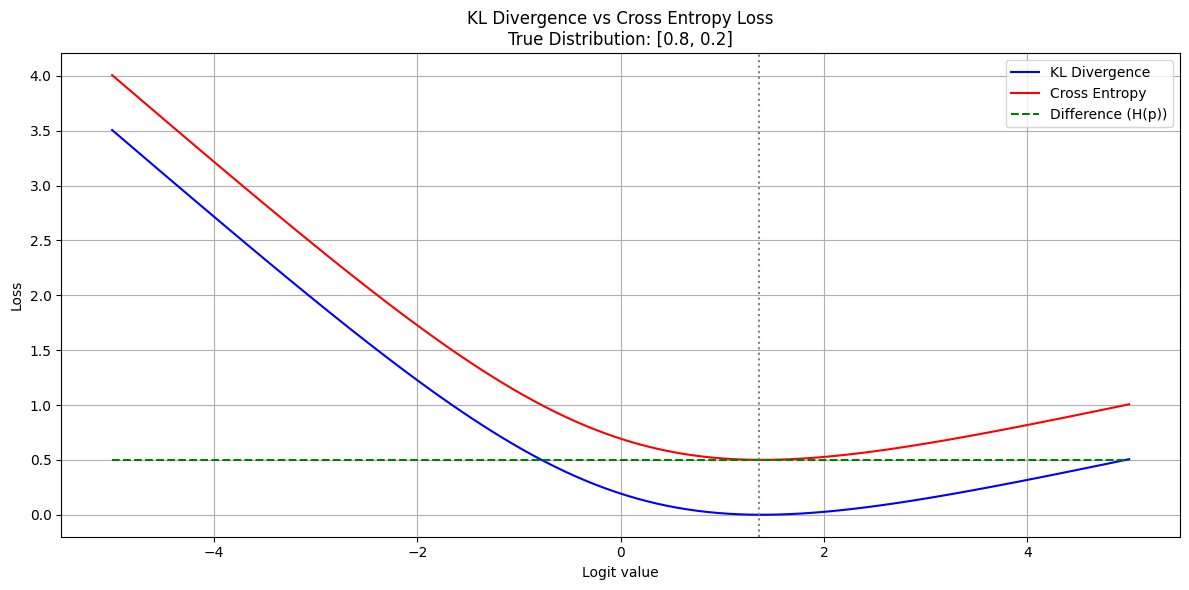


Optimal logits: [1.364, 0]
Resulting probabilities: [0.796, 0.204]
True probabilities: [0.800, 0.200]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

def compute_kl_divergence(p, q):
    """Compute KL divergence between distributions p and q"""
    return np.sum(p * np.log(p / q))

def compute_cross_entropy(p, q):
    """Compute cross entropy between distributions p and q"""
    return -np.sum(p * np.log(q))

# Create true distribution (one-hot vector)
true_dist = np.array([0.8, 0.2])  # Example true probabilities

# Initialize lists to store metrics
kl_divergences = []
cross_entropies = []
steps = []

# Create range of logits to visualize
logits = np.linspace(-5, 5, 100)
for logit in logits:
    # Create predicted distribution using softmax
    pred_logits = np.array([logit, 0])  # Keep one logit fixed at 0
    pred_dist = softmax(pred_logits)
    
    # Compute KL divergence and cross entropy
    kl_div = compute_kl_divergence(true_dist, pred_dist)
    cross_ent = compute_cross_entropy(true_dist, pred_dist)
    
    # Store results
    kl_divergences.append(kl_div)
    cross_entropies.append(cross_ent)
    steps.append(logit)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot KL divergence
plt.plot(steps, kl_divergences, label='KL Divergence', color='blue')

# Plot Cross Entropy
plt.plot(steps, cross_entropies, label='Cross Entropy', color='red')

# Plot the difference (should be constant, equal to entropy of true distribution)
plt.plot(steps, np.array(cross_entropies) - np.array(kl_divergences), 
         label='Difference (H(p))', color='green', linestyle='--')

plt.xlabel('Logit value')
plt.ylabel('Loss')
plt.title('KL Divergence vs Cross Entropy Loss\nTrue Distribution: [0.8, 0.2]')
plt.legend()
plt.grid(True)

# Add vertical line at minimum
min_idx = np.argmin(kl_divergences)
plt.axvline(x=steps[min_idx], color='gray', linestyle=':', 
            label=f'Minimum at x={steps[min_idx]:.2f}')

# Show the plot
plt.tight_layout()
plt.show()

# Print the optimal logits and resulting probabilities
optimal_logits = np.array([steps[min_idx], 0])
optimal_probs = softmax(optimal_logits)
print(f"\nOptimal logits: [{steps[min_idx]:.3f}, 0]")
print(f"Resulting probabilities: [{optimal_probs[0]:.3f}, {optimal_probs[1]:.3f}]")
print(f"True probabilities: [{true_dist[0]:.3f}, {true_dist[1]:.3f}]")

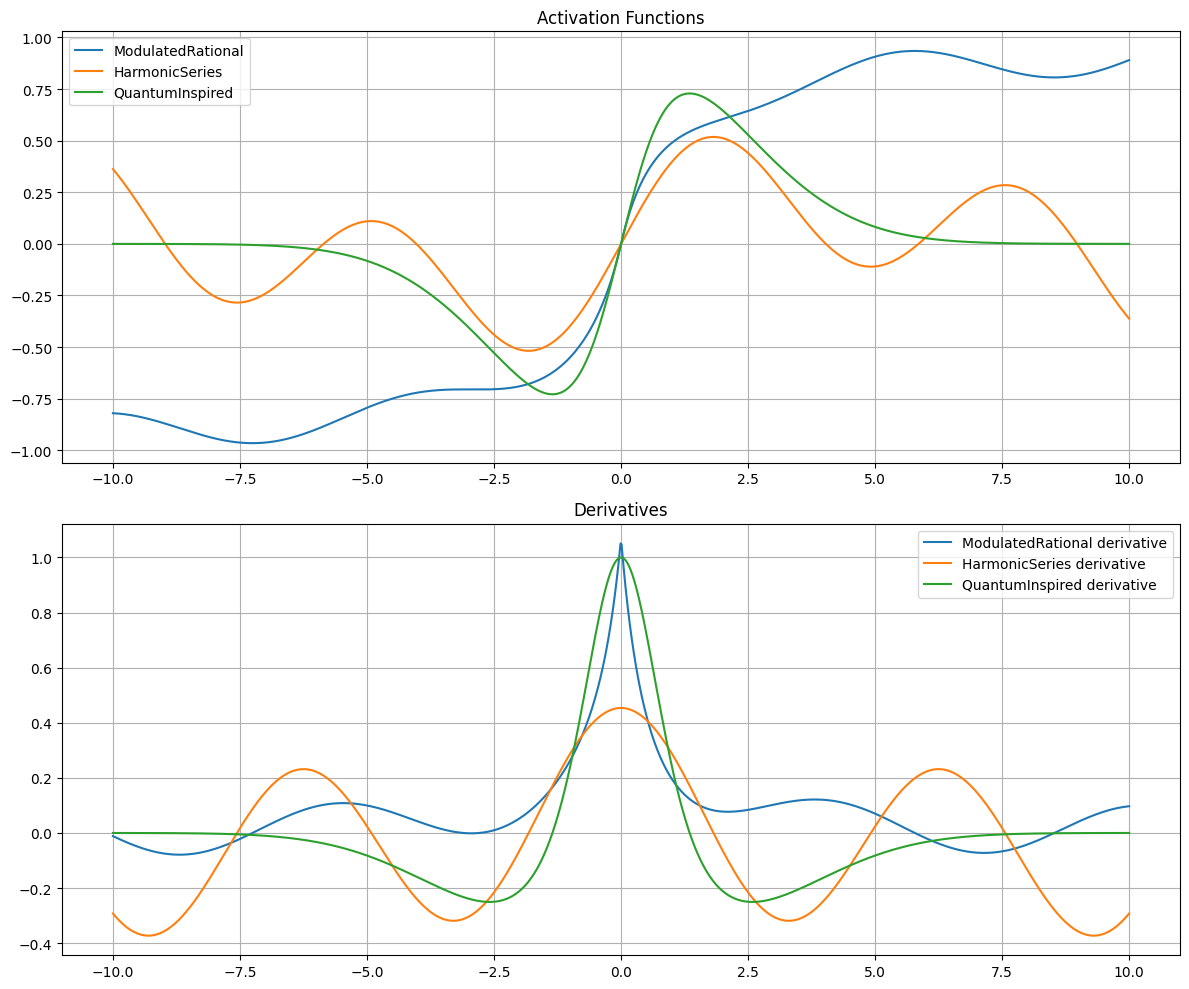


Activation Function Properties:
--------------------------------------------------

ModulatedRational:
range: (-0.9652241523830145, 0.9343844870906877)
monotonic: False
max_derivative: 1.050976762249911
zero_centered: True
bounded: True
Benchmark time: 0.016304 seconds

HarmonicSeries:
range: (-0.5179613917460301, 0.5179613917460301)
monotonic: False
max_derivative: 0.4536857538695732
zero_centered: True
bounded: True
Benchmark time: 0.036691 seconds

QuantumInspired:
range: (-0.7284294080475793, 0.7284294080475793)
monotonic: False
max_derivative: 0.9998697482298258
zero_centered: True
bounded: True
Benchmark time: 0.017626 seconds


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import torch
import torch.nn as nn

class ActivationAnalyzer:
    def __init__(self, name, func, derivative=None):
        self.name = name
        self.func = func
        self._derivative = derivative
        
    def derivative(self, x):
        if self._derivative is not None:
            return self._derivative(x)
        # Numerical derivative if not provided
        h = 1e-7
        return (self.func(x + h) - self.func(x - h)) / (2 * h)
    
    def analyze_properties(self, x_range=np.linspace(-10, 10, 1000)):
        """Analyze key properties of the activation function"""
        y = self.func(x_range)
        dy = self.derivative(x_range)
        
        properties = {
            "range": (float(np.min(y)), float(np.max(y))),
            "monotonic": np.all(dy >= 0) or np.all(dy <= 0),
            "max_derivative": float(np.max(np.abs(dy))),
            "zero_centered": np.abs(self.func(0)) < 1e-7,
            "bounded": np.all(np.abs(y) < 100),  # arbitrary threshold
        }
        
        return properties
    
    def benchmark(self, size=1000000):
        """Measure computational efficiency"""
        x = np.random.randn(size)
        
        start = perf_counter()
        _ = self.func(x)
        end = perf_counter()
        
        return end - start

def plot_activation_comparison(activations, x_range=np.linspace(-10, 10, 1000)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    for activation in activations:
        y = activation.func(x_range)
        dy = activation.derivative(x_range)
        
        ax1.plot(x_range, y, label=activation.name)
        ax2.plot(x_range, dy, label=f"{activation.name} derivative")
    
    ax1.set_title("Activation Functions")
    ax1.grid(True)
    ax1.legend()
    
    ax2.set_title("Derivatives")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Define some interesting new activation functions
def modulated_rational(x):
    """A new activation function combining rational and modulation terms"""
    x = np.asarray(x)
    phase = np.pi / 4  # This creates interesting asymmetry
    modulation = 1 + 0.1 * np.cos(x + phase)
    return (x * modulation) / (1 + np.abs(x))

def harmonic_series(x, terms=3):
    """Activation based on harmonic series truncation"""
    x = np.asarray(x)
    result = np.zeros_like(x, dtype=np.float64)
    for n in range(1, terms + 1):
        result += np.sin(x/n) / n
    return result / terms

def quantum_inspired(x):
    """Inspired by quantum mechanics wavefunctions"""
    x = np.asarray(x)
    return np.tanh(x) * np.exp(-0.1 * x**2)

# Create analyzers for our functions
activations = [
    ActivationAnalyzer("ModulatedRational", modulated_rational),
    ActivationAnalyzer("HarmonicSeries", harmonic_series),
    ActivationAnalyzer("QuantumInspired", quantum_inspired),
]

# Analyze and plot
plot_activation_comparison(activations)
plt.show()

# Print properties
print("\nActivation Function Properties:")
print("-" * 50)
for activation in activations:
    props = activation.analyze_properties()
    print(f"\n{activation.name}:")
    for prop, value in props.items():
        print(f"{prop}: {value}")
    print(f"Benchmark time: {activation.benchmark():.6f} seconds")

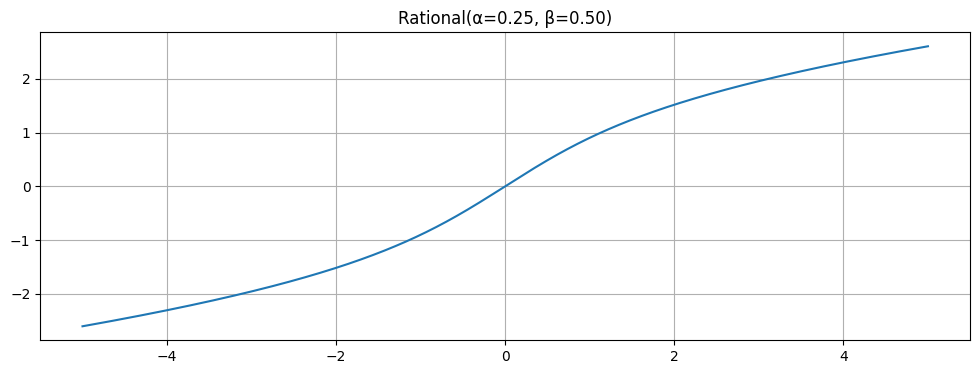

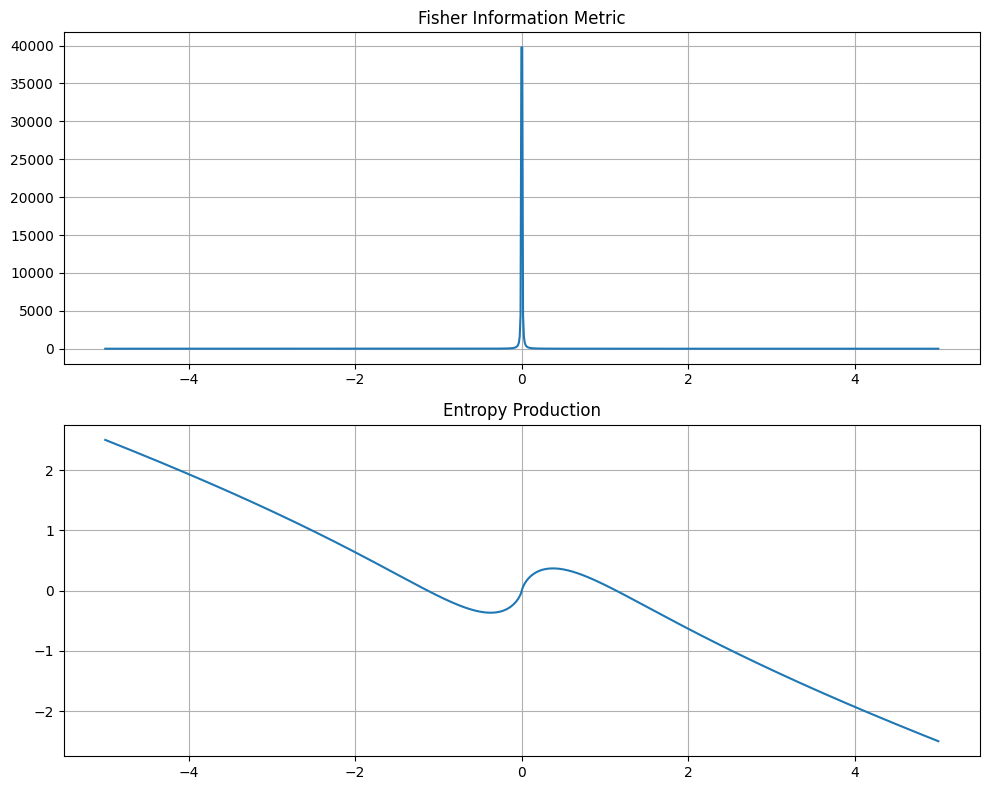

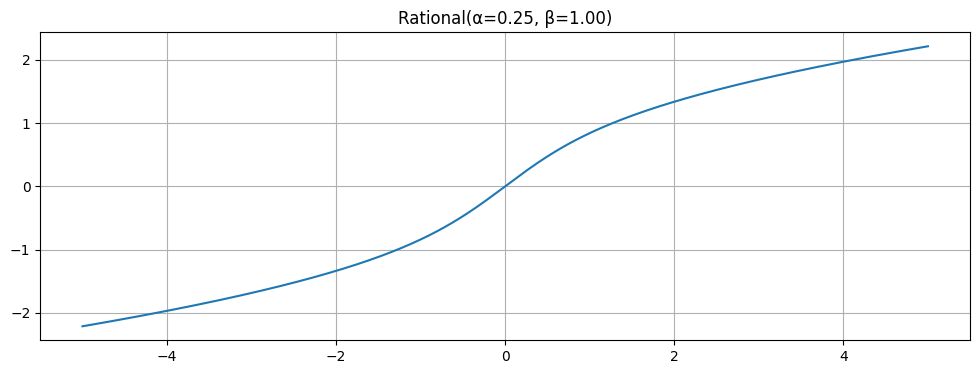

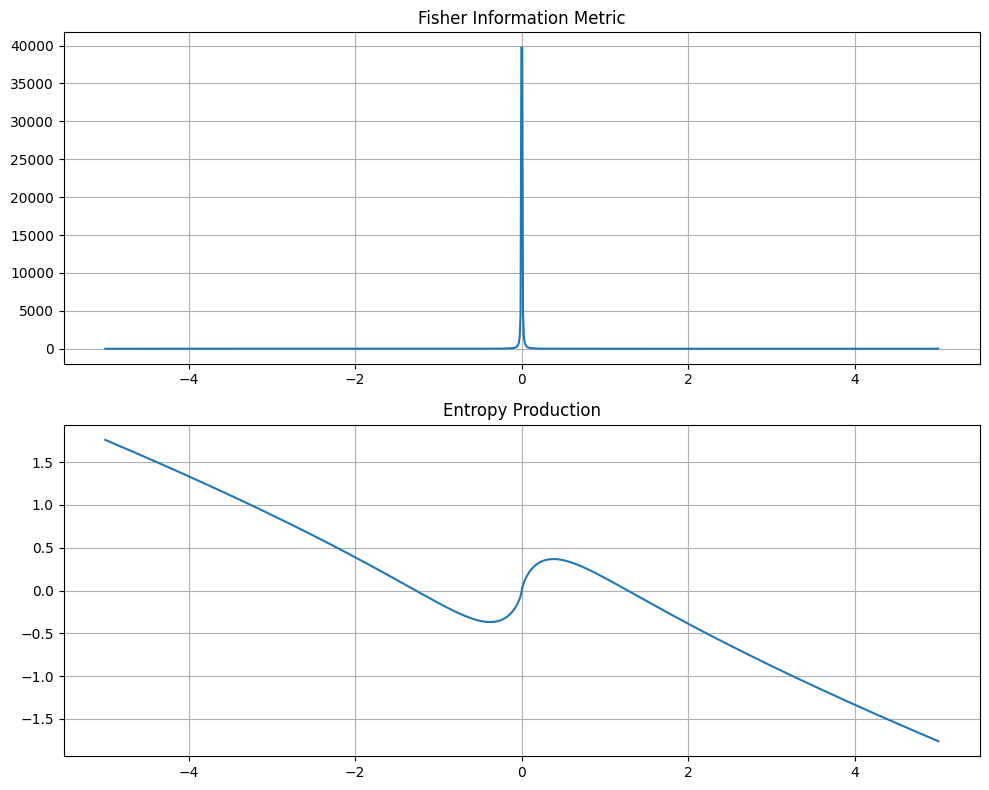

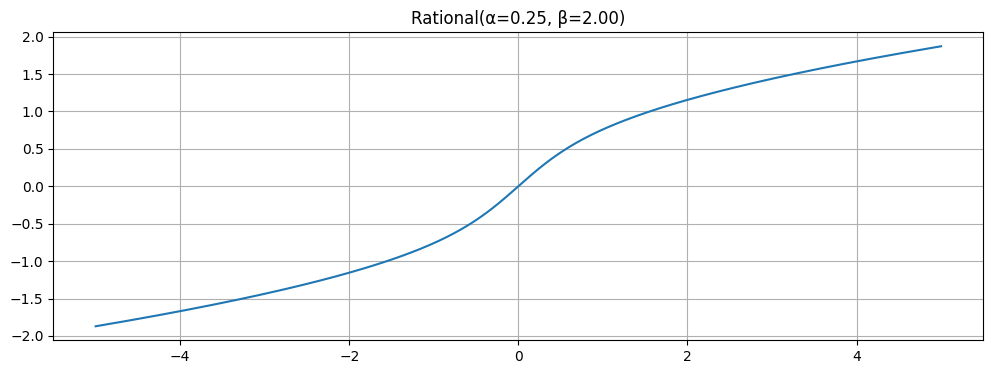

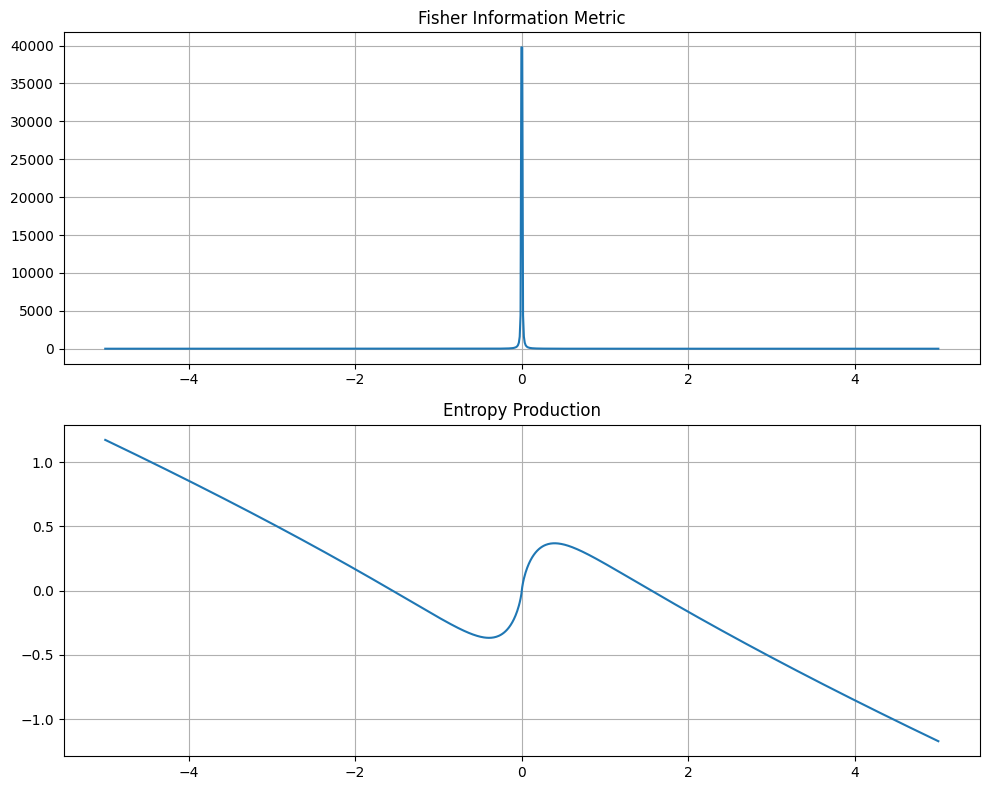

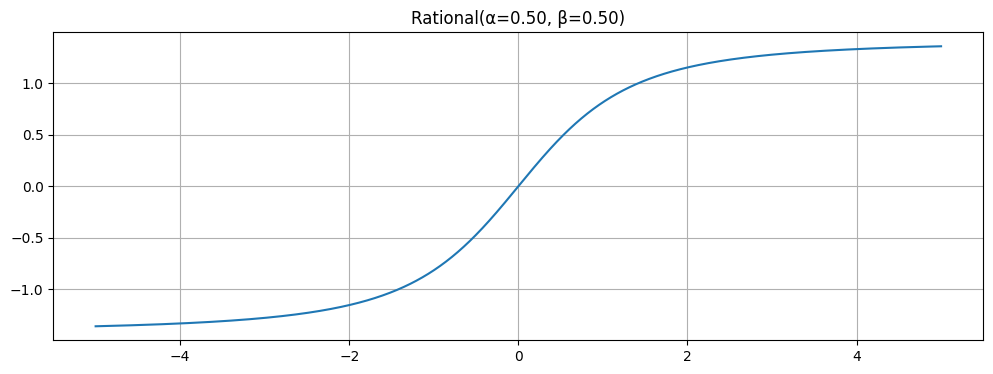

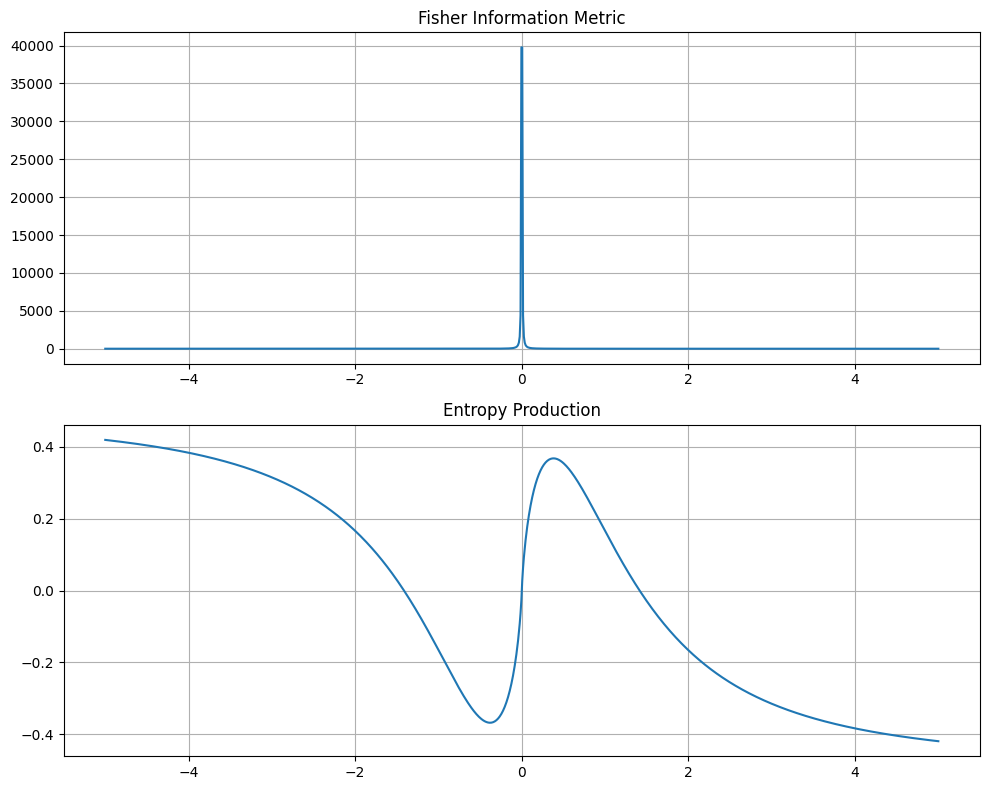

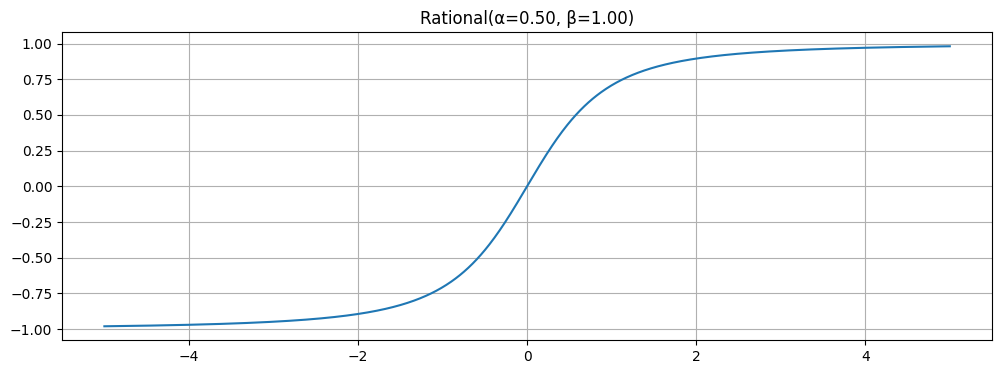

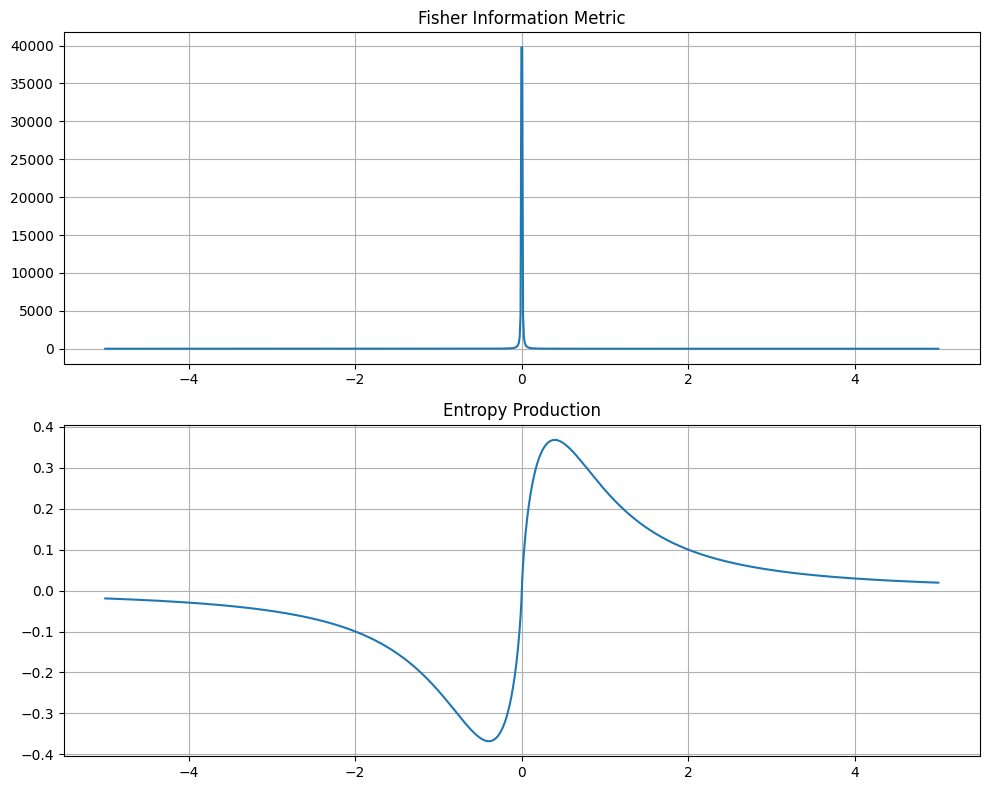

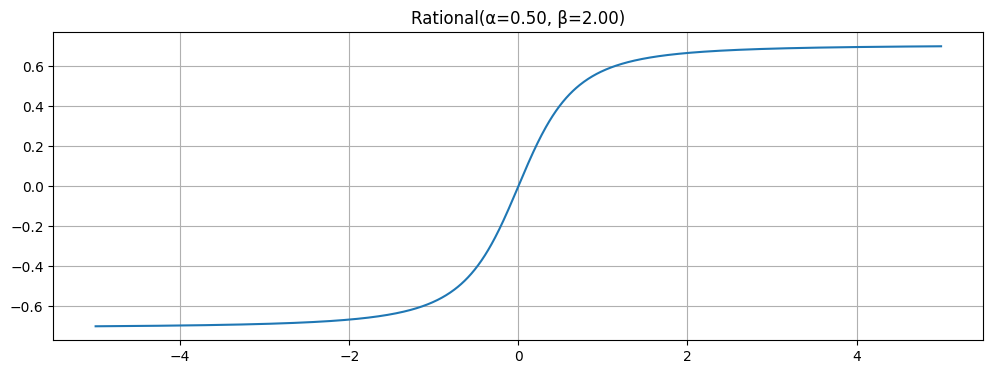

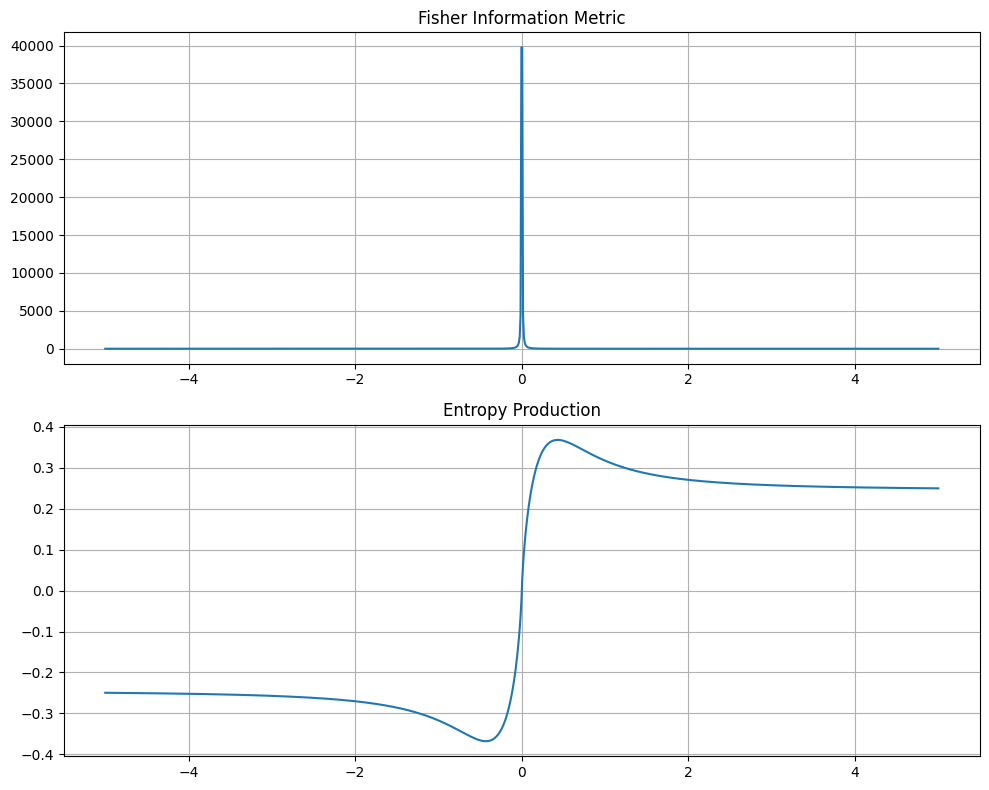

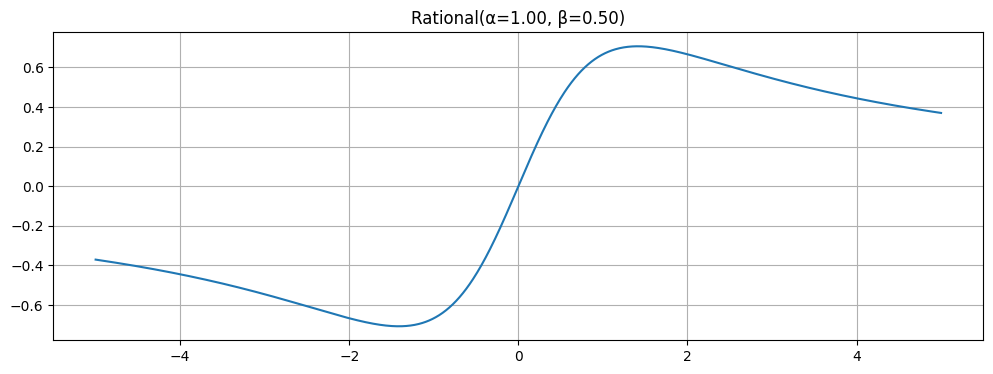

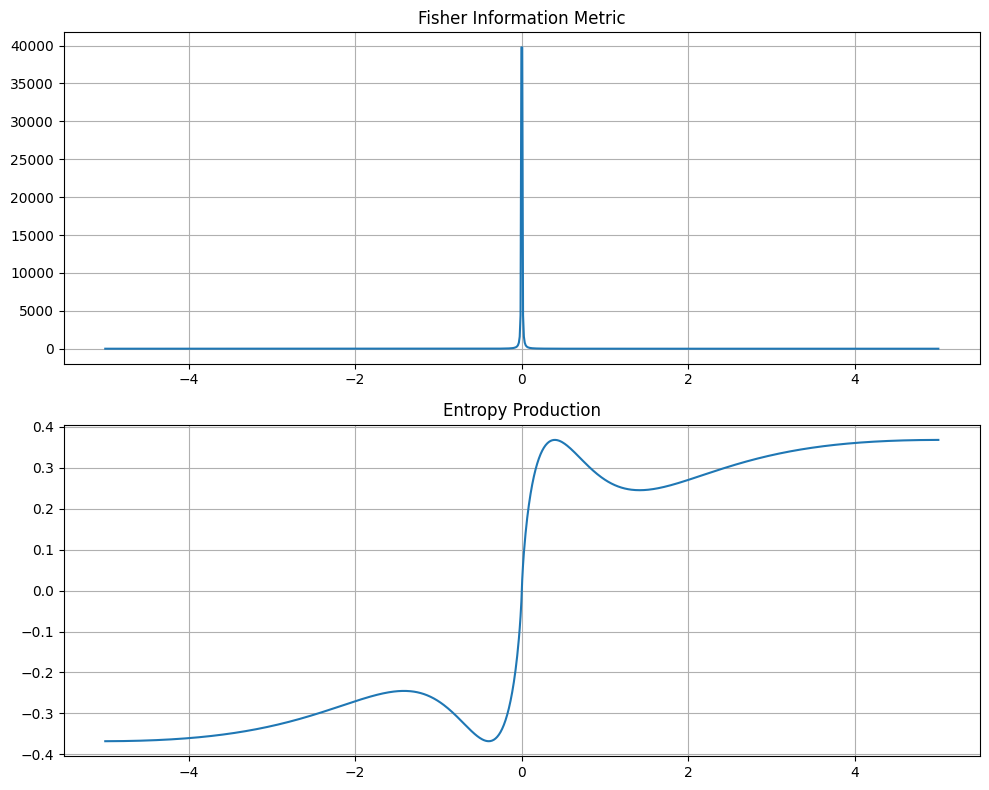

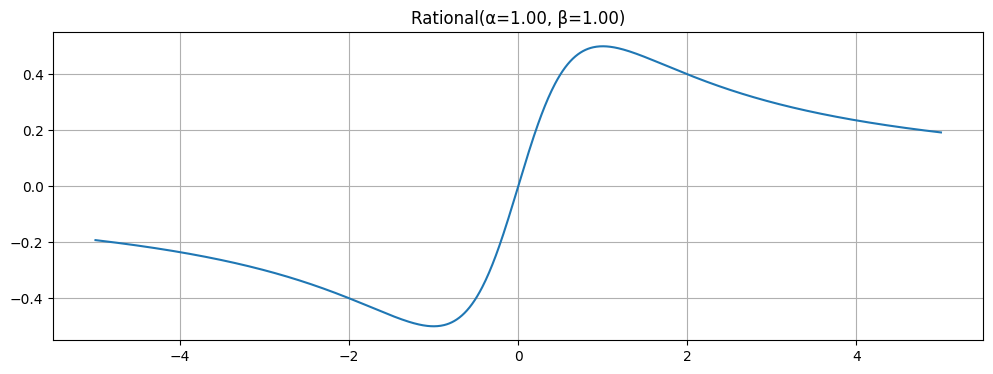

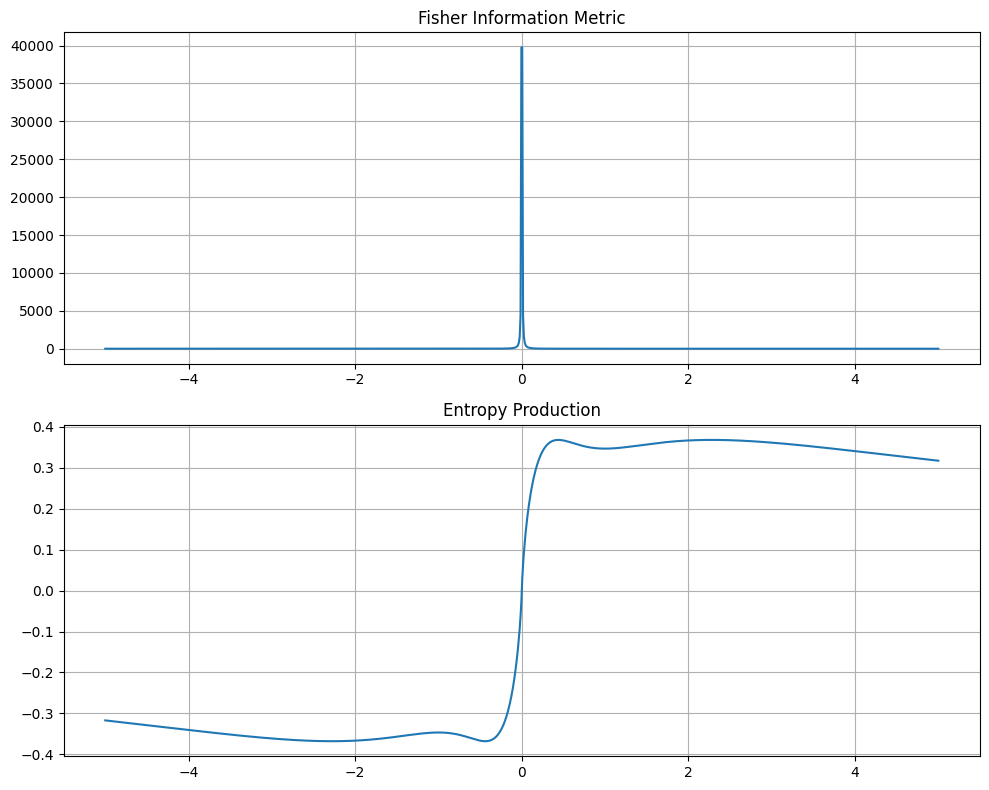

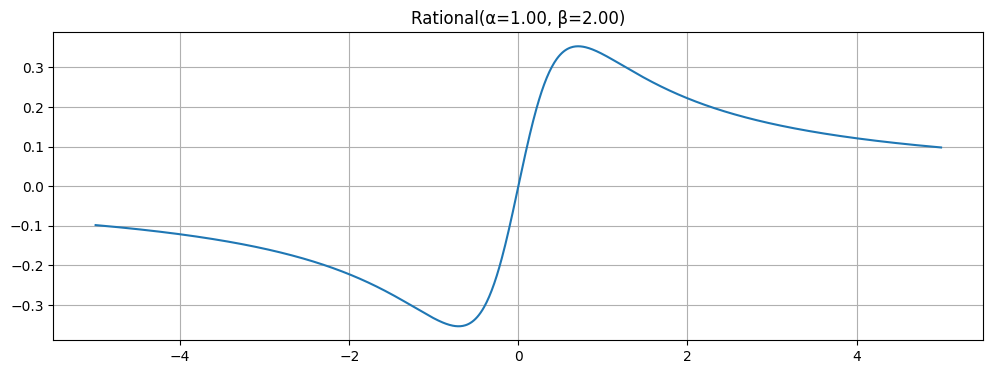

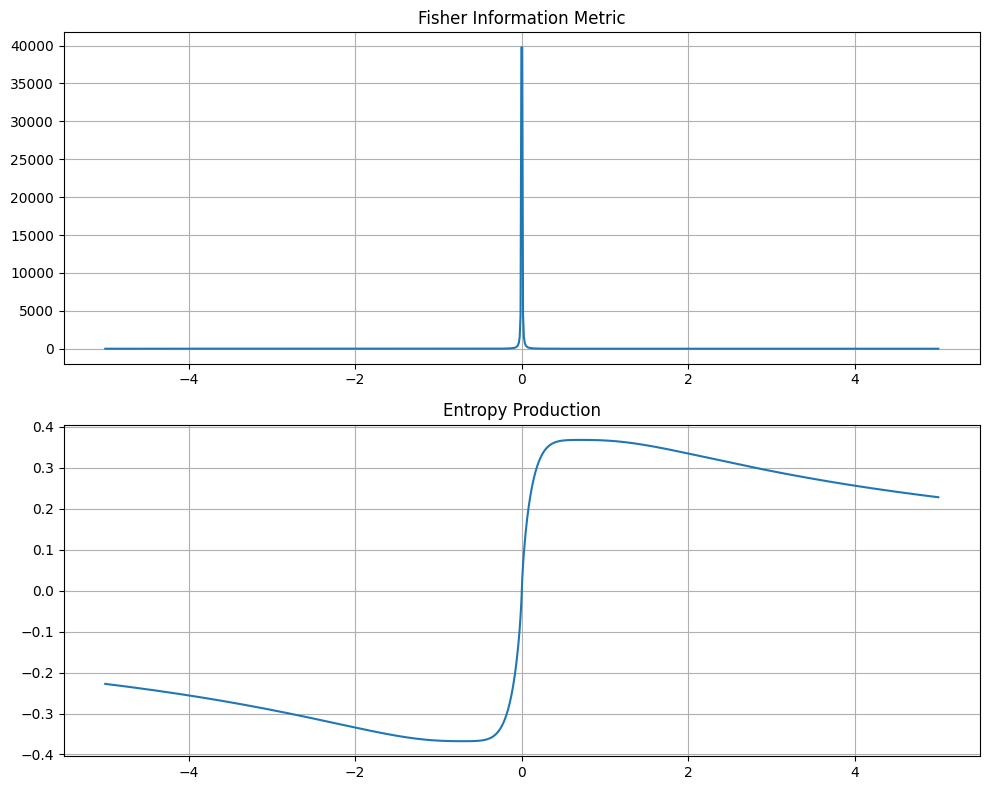

In [3]:
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import quad
import matplotlib.pyplot as plt

class InformationAnalyzer:
    def __init__(self, activation_fn):
        self.activation = activation_fn
        
    def fisher_information(self, x, eps=1e-7):
        """Compute Fisher information metric at point x"""
        # Compute (f'(x))^2 / f(x)
        y = self.activation(x)
        dy = (self.activation(x + eps) - self.activation(x - eps)) / (2 * eps)
        return dy * dy / (y * y + eps)
    
    def entropy_production(self, x_range=np.linspace(-5, 5, 1000)):
        """Analyze entropy production rate"""
        y = self.activation(x_range)
        # Compute -y log(y)
        eps = 1e-7
        entropy = -y * np.log(np.abs(y) + eps)
        return entropy
    
    def visualize_information_properties(self, x_range=np.linspace(-5, 5, 1000)):
        """Create visualization of information-theoretic properties"""
        fisher = np.array([self.fisher_information(x) for x in x_range])
        entropy = self.entropy_production(x_range)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(x_range, fisher)
        ax1.set_title("Fisher Information Metric")
        ax1.grid(True)
        
        ax2.plot(x_range, entropy)
        ax2.set_title("Entropy Production")
        ax2.grid(True)
        
        plt.tight_layout()
        return fig

# Define a new family of activation functions
def generalized_rational(x, alpha=0.5, beta=1.0):
    """
    A generalized rational function with tunable parameters
    alpha: controls the growth rate
    beta: controls the transition sharpness
    """
    x = np.asarray(x)
    return x * (1 + (beta * x * x))**(-alpha)

# Create analyzers for different parameter settings
alphas = [0.25, 0.5, 1.0]
betas = [0.5, 1.0, 2.0]

for alpha in alphas:
    for beta in betas:
        name = f"Rational(α={alpha:.2f}, β={beta:.2f})"
        analyzer = InformationAnalyzer(
            lambda x, a=alpha, b=beta: generalized_rational(x, a, b)
        )
        
        plt.figure(figsize=(12, 4))
        plt.title(name)
        x = np.linspace(-5, 5, 1000)
        plt.plot(x, generalized_rational(x, alpha, beta))
        plt.grid(True)
        plt.show()
        
        analyzer.visualize_information_properties()
        plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]/home/dnhkng/miniconda3/envs/exllamav2/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


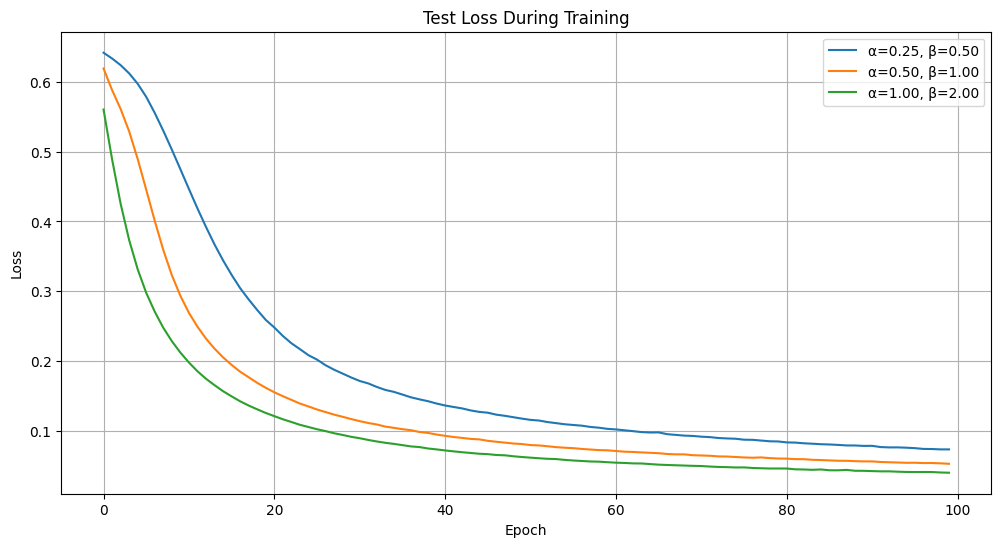

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

class GeneralizedRationalNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, alpha=0.5, beta=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
    def rational_activation(self, x):
        return x * (1 + (self.beta * x * x)).pow(-self.alpha)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.rational_activation(x)
        x = self.layer2(x)
        return x

def generate_synthetic_data(n_samples=10000):
    """Generate a synthetic classification problem"""
    X = torch.randn(n_samples, 2)
    # Create a non-linear decision boundary
    y = ((X[:, 0]**2 + X[:, 1]**2) < 2).float()
    return X, y

def train_and_evaluate(model, train_loader, test_loader, epochs=100):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())
    
    train_losses = []
    test_losses = []
    
    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        epoch_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        
        # Evaluation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                output = model(X)
                loss = criterion(output.squeeze(), y)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))
    
    return train_losses, test_losses

# Generate data
X_train, y_train = generate_synthetic_data(10000)
X_test, y_test = generate_synthetic_data(2000)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

# Test different parameter settings
parameter_settings = [
    (0.25, 0.5),
    (0.5, 1.0),
    (1.0, 2.0)
]

results = {}
for alpha, beta in parameter_settings:
    model = GeneralizedRationalNet(2, 32, 1, alpha, beta)
    train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader)
    results[(alpha, beta)] = (train_losses, test_losses)

# Visualize results
plt.figure(figsize=(12, 6))
for (alpha, beta), (train_losses, test_losses) in results.items():
    plt.plot(test_losses, label=f'α={alpha:.2f}, β={beta:.2f}')
plt.title('Test Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import numpy as np
import torch
from time import perf_counter

class ActivationAnalyzer:
    def __init__(self, name, func, derivative=None):
        self.name = name
        self.func = func
        self._derivative = derivative
        
    def derivative(self, x):
        if self._derivative is not None:
            return self._derivative(x)
        h = 1e-7
        return (self.func(x + h) - self.func(x - h)) / (2 * h)
    
    def analyze_properties(self, x_range=np.linspace(-10, 10, 1000)):
        """Analyze key properties of the activation function"""
        y = self.func(x_range)
        dy = self.derivative(x_range)
        
        # Additional analysis
        x_small = np.linspace(-0.1, 0.1, 1000)  # behavior near zero
        y_small = self.func(x_small)
        dy_small = self.derivative(x_small)
        
        properties = {
            "range": (float(np.min(y)), float(np.max(y))),
            "monotonic": np.all(dy >= -1e-7) or np.all(dy <= 1e-7),
            "max_derivative": float(np.max(np.abs(dy))),
            "min_derivative": float(np.min(np.abs(dy[np.abs(dy) > 1e-7]))),
            "zero_centered": np.abs(self.func(0)) < 1e-7,
            "bounded": np.all(np.abs(y) < 100),
            "linear_near_zero": np.std(dy_small) < 0.1,  # Check if derivative is roughly constant near 0
            "derivative_range": (float(np.min(dy)), float(np.max(dy))),
            "saturation_point": float(np.min(np.abs(x_range[np.abs(y) > 0.95 * np.max(np.abs(y))])))
        }
        
        return properties
    
    def benchmark(self, size=1000000):
        """Measure computational efficiency"""
        x = np.random.randn(size)
        
        start = perf_counter()
        _ = self.func(x)
        end = perf_counter()
        
        return end - start

# Original functions from the question
def squash_activation(x, double_squash=True):
    x = np.asarray(x)
    abs_x = np.abs(x)
    if double_squash:
        return x / (1 + 2 * abs_x)
    return x / (1 + abs_x)

def smooth_rational(x):
    x = np.asarray(x)
    numerator = x * (1 + x**2)**0.25
    denominator = 1 + np.abs(x)**3
    return numerator / denominator

def logistic_bounded(x):
    x = np.asarray(x)
    scale = np.log1p(np.abs(x))
    return np.tanh(x / (1 + scale))

def harmonic_squash(x):
    x = np.asarray(x)
    sign = np.sign(x)
    return sign * (np.abs(x) / (1 + np.sqrt(1 + x**2)))

# Create analyzers for all functions
activations = [
    ActivationAnalyzer("SquashDouble", lambda x: squash_activation(x, True)),
    ActivationAnalyzer("SquashSingle", lambda x: squash_activation(x, False)),
    ActivationAnalyzer("SmoothRational", smooth_rational),
    ActivationAnalyzer("LogisticBounded", logistic_bounded),
    ActivationAnalyzer("HarmonicSquash", harmonic_squash)
]

# Add some analysis of curvature and inflection points
def analyze_curvature(activation, x_range=np.linspace(-10, 10, 1000)):
    y = activation.func(x_range)
    dy = activation.derivative(x_range)
    
    # Approximate second derivative
    h = 1e-5
    d2y = (activation.derivative(x_range + h) - activation.derivative(x_range - h)) / (2 * h)
    
    inflection_points = []
    for i in range(1, len(d2y)-1):
        if d2y[i-1] * d2y[i+1] < 0:
            inflection_points.append(x_range[i])
    
    return {
        "max_curvature": float(np.max(np.abs(d2y))),
        "inflection_points": [float(x) for x in inflection_points[:5]],  # First 5 inflection points
        "curvature_range": (float(np.min(d2y)), float(np.max(d2y)))
    }

# Print detailed analysis
print("\nDetailed Activation Function Analysis:")
print("-" * 80)
for activation in activations:
    print(f"\n{activation.name}:")
    props = activation.analyze_properties()
    curv = analyze_curvature(activation)
    
    print("Basic Properties:")
    for prop, value in props.items():
        print(f"  {prop}: {value}")
    
    print("\nCurvature Analysis:")
    for prop, value in curv.items():
        print(f"  {prop}: {value}")
    
    print(f"\nBenchmark time: {activation.benchmark():.6f} seconds")
    print("-" * 80)

# Additional numerical stability test
def test_numerical_stability(activation):
    # Test with very large values
    large_x = np.array([1e10, 1e20, 1e30])
    try:
        large_y = activation.func(large_x)
        large_stable = not np.any(np.isnan(large_y)) and not np.any(np.isinf(large_y))
    except:
        large_stable = False
    
    # Test with very small values
    small_x = np.array([1e-10, 1e-20, 1e-30])
    try:
        small_y = activation.func(small_x)
        small_stable = not np.any(np.isnan(small_y)) and not np.any(np.isinf(small_y))
    except:
        small_stable = False
        
    return {
        "stable_for_large_values": large_stable,
        "stable_for_small_values": small_stable,
        "large_value_output": large_y.tolist() if large_stable else None,
        "small_value_output": small_y.tolist() if small_stable else None
    }

print("\nNumerical Stability Analysis:")
print("-" * 80)
for activation in activations:
    print(f"\n{activation.name}:")
    stability = test_numerical_stability(activation)
    for prop, value in stability.items():
        print(f"  {prop}: {value}")


Detailed Activation Function Analysis:
--------------------------------------------------------------------------------

SquashDouble:
Basic Properties:
  range: (-0.47619047619047616, 0.47619047619047616)
  monotonic: True
  max_derivative: 0.9611310517257388
  min_derivative: 0.00226757362886687
  zero_centered: True
  bounded: True
  linear_near_zero: True
  derivative_range: (0.00226757362886687, 0.9611310517257388)
  saturation_point: 4.754754754754755

Curvature Analysis:
  max_curvature: 3.76906752336259
  inflection_points: [-0.010010010010010006, 0.010010010010010006]
  curvature_range: (-3.76906752336259, 3.76906752336259)

Benchmark time: 0.005182 seconds
--------------------------------------------------------------------------------

SquashSingle:
Basic Properties:
  range: (-0.9090909090909091, 0.9090909090909091)
  monotonic: True
  max_derivative: 0.9802766184549561
  min_derivative: 0.008264462447726828
  zero_centered: True
  bounded: True
  linear_near_zero: True
  

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
class OutputActivation(nn.Module):
    """Base class for output activation functions."""
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
    def loss(self, logits: torch.Tensor, targets: torch.Tensor, ignore_index: int = -1) -> torch.Tensor:
        raise NotImplementedError

class SoftmaxActivation(OutputActivation):
    """Standard softmax activation with cross entropy loss for comparison."""
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.softmax(x, dim=-1)
    
    def loss(self, logits: torch.Tensor, targets: torch.Tensor, ignore_index: int = -1) -> torch.Tensor:
        return F.cross_entropy(
            logits.view(-1, logits.size(-1)), 
            targets.view(-1),
            ignore_index=ignore_index
        )


class LogisticBoundedActivationArcTan(OutputActivation):
    """
    LogisticBounded activation with automatic normalization.
    Converts raw logits to probabilities using tanh with adaptive scaling.
    """
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Scale the logits adaptively using log1p
        scale = torch.arctan(torch.abs(x)) * 2/math.pi
        # Apply bounded activation
        bounded = torch.tanh(x / (1 + scale))
        # Convert from [-1,1] to [0,1] and normalize
        probs = (bounded + 1) / 2
        return probs / probs.sum(dim=-1, keepdim=True)
    

    def loss(self, logits: torch.Tensor, targets: torch.Tensor, ignore_index: int = -1) -> torch.Tensor:
        # Get probabilities
        probs = self.forward(logits)
        # Add small epsilon to avoid log(0)
        eps = 1e-10
        log_probs = torch.log(probs + eps)
        # Calculate cross entropy loss using scatter
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(-1, targets.unsqueeze(-1), 1)
        loss = -torch.sum(targets_one_hot * log_probs, dim=-1)
        # Handle ignored indices
        if ignore_index >= 0:
            mask = targets != ignore_index
            loss = loss[mask]
        return loss.mean()

class SmoothScaledActivation(OutputActivation):
    """
    Uses a smooth scaling function that combines local and global information.
    Should provide good scaling across different magnitude ranges.
    """
    def __init__(self, temperature: float = 1.0):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Combine local and global scaling
        local_scale = torch.abs(x)
        global_scale = torch.mean(local_scale, dim=-1, keepdim=True)
        
        # Smooth transition between scales
        alpha = torch.sigmoid(local_scale - global_scale)
        scale = alpha * local_scale + (1 - alpha) * global_scale
        
        x_scaled = x / (torch.log1p(scale) / self.temperature + 1e-5)
        activated = torch.sigmoid(x_scaled)
        return activated / (torch.sum(activated, dim=-1, keepdim=True) + 1e-10)

    def loss(self, logits: torch.Tensor, targets: torch.Tensor, ignore_index: int = -1) -> torch.Tensor:
        probs = self.forward(logits)
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(-1, targets.unsqueeze(-1), 1)
        loss = -torch.sum(targets_one_hot * torch.log(probs + 1e-10), dim=-1)
        if ignore_index >= 0:
            mask = targets != ignore_index
            loss = loss[mask]
        return loss.mean()

class FastBoundedActivation(OutputActivation):
    """
    Fast converging bounded activation that maintains good gradient flow.
    Uses a simpler, more direct approach for better convergence speed.
    """
    
    def __init__(self, temperature: float = 1.0):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Scale the input for better gradient flow
        x = x / self.temperature
        
        # Use sigmoid for bounding with good gradient properties
        activated = torch.sigmoid(x)
        
        # Simple normalization
        return activated / (torch.sum(activated, dim=-1, keepdim=True) + 1e-10)

    def loss(self, logits: torch.Tensor, targets: torch.Tensor, ignore_index: int = -1) -> torch.Tensor:
        # Get probabilities
        probs = self.forward(logits)
        
        # Convert targets to one-hot
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(-1, targets.unsqueeze(-1), 1)
        
        # Simple cross entropy with minimal overhead
        loss = -torch.sum(targets_one_hot * torch.log(probs + 1e-10), dim=-1)
        
        # Handle ignored indices
        if ignore_index >= 0:
            mask = targets != ignore_index
            loss = loss[mask]
        
        return loss.mean()


def analyze_gradient_flow(activation_class, input_range=(-10, 10), num_points=1000, temps=[0.5, 1.0, 2.0, 4.0]):
    """Analyze gradient flow through activation function at different temperatures"""
    x = torch.linspace(input_range[0], input_range[1], num_points, requires_grad=True)
    batch_x = x.unsqueeze(0).expand(10, -1)  # Add batch dimension
    
    results = {}
    for temp in temps:
        if hasattr(activation_class, 'temperature'):
            activation = activation_class(temperature=temp)
        else:
            activation = activation_class()
        
        # Forward pass
        output = activation(batch_x)
        
        # Compute gradients with respect to different target distributions
        grads = []
        for i in range(5):  # Test different target distributions
            target = torch.zeros_like(batch_x)
            target[:, i*200:(i+1)*200] = 1.0  # Create different target hot spots
            target = target / target.sum(dim=1, keepdim=True)
            
            loss = -torch.sum(target * torch.log(output + 1e-10))
            loss.backward(retain_graph=True)
            grads.append(x.grad.clone())
            x.grad.zero_()
        
        avg_grad = torch.stack(grads).mean(0)
        grad_std = torch.stack(grads).std(0)
        
        results[temp] = {
            'output': output[0].detach().numpy(),
            'grad_mean': avg_grad.numpy(),
            'grad_std': grad_std.numpy(),
            'x': x.detach().numpy()
        }
    
    return results



def analyze_temperature_scaling(activation_class, logit_scales=[1, 10, 100, 1000], temps=[0.5, 1.0, 2.0, 4.0]):
    """Analyze how different temperatures handle varying logit scales"""
    vocab_size = 1000
    batch_size = 32
    results = {}
    
    for scale in logit_scales:
        scale_results = {}
        
        # Generate test logits with different scales
        logits = torch.randn(batch_size, vocab_size) * scale
        targets = torch.randint(0, vocab_size, (batch_size,))
        
        for temp in temps:
            if hasattr(activation_class, 'temperature'):
                activation = activation_class(temperature=temp)
            else:
                activation = activation_class()
            
            # Forward pass
            probs = activation(logits)
            
            # Compute metrics
            entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=-1).mean()
            top1_conf = probs.max(dim=-1)[0].mean()
            target_probs = probs[torch.arange(batch_size), targets].mean()
            
            scale_results[temp] = {
                'entropy': entropy.item(),
                'top1_confidence': top1_conf.item(),
                'target_prob': target_probs.item()
            }
        
        results[scale] = scale_results
    
    return results

# Test the best performing activations
activations = {
    'FastBounded': FastBoundedActivation,
    'SmoothScaled': SmoothScaledActivation,
    'LogisticBoundedArcTan': LogisticBoundedActivationArcTan,
    'Softmax': SoftmaxActivation
}

# Analyze gradient flow
gradient_results = {}
for name, act_class in activations.items():
    print(f"Analyzing gradient flow for {name}...")
    gradient_results[name] = analyze_gradient_flow(act_class)

# Analyze temperature scaling
temp_results = {}
for name, act_class in activations.items():
    print(f"Analyzing temperature scaling for {name}...")
    temp_results[name] = analyze_temperature_scaling(act_class)

# Print summary statistics
print("\nTemperature Scaling Analysis:")
print("-" * 80)
for name, results in temp_results.items():
    print(f"\n{name}:")
    for scale, scale_results in results.items():
        print(f"\nLogit scale: {scale}")
        for temp, metrics in scale_results.items():
            print(f"  Temperature {temp}:")
            for metric, value in metrics.items():
                print(f"    {metric}: {value:.4f}")

# Return detailed results for further analysis
detailed_results = {
    'gradient_flow': gradient_results,
    'temperature_scaling': temp_results
}

# Calculate gradient statistics
gradient_stats = {}
for name, results in gradient_results.items():
    stats = {}
    for temp, data in results.items():
        grad_mean = data['grad_mean']
        grad_std = data['grad_std']
        stats[temp] = {
            'max_grad': np.max(np.abs(grad_mean)),
            'mean_grad': np.mean(np.abs(grad_mean)),
            'grad_std': np.mean(grad_std)
        }
    gradient_stats[name] = stats

print("\nGradient Flow Analysis:")
print("-" * 80)
for name, stats in gradient_stats.items():
    print(f"\n{name}:")
    for temp, metrics in stats.items():
        print(f"  Temperature {temp}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")

Analyzing gradient flow for FastBounded...
Analyzing gradient flow for SmoothScaled...
Analyzing gradient flow for LogisticBoundedArcTan...
Analyzing gradient flow for Softmax...
Analyzing temperature scaling for FastBounded...
Analyzing temperature scaling for SmoothScaled...
Analyzing temperature scaling for LogisticBoundedArcTan...
Analyzing temperature scaling for Softmax...

Temperature Scaling Analysis:
--------------------------------------------------------------------------------

FastBounded:

Logit scale: 1
  Temperature 0.5:
    entropy: 6.8146
    top1_confidence: 0.0019
    target_prob: 0.0011
  Temperature 1.0:
    entropy: 6.8146
    top1_confidence: 0.0019
    target_prob: 0.0011
  Temperature 2.0:
    entropy: 6.8146
    top1_confidence: 0.0019
    target_prob: 0.0011
  Temperature 4.0:
    entropy: 6.8146
    top1_confidence: 0.0019
    target_prob: 0.0011

Logit scale: 10
  Temperature 0.5:
    entropy: 6.3402
    top1_confidence: 0.0020
    target_prob: 0.0011
  Te

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FastBoundedWithTempDebug(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, x, return_intermediates=False):
        intermediates = {}
        
        x_scaled = x / self.temperature
        intermediates['post_temp_scale'] = x_scaled.clone()
        
        activated = torch.sigmoid(x_scaled)
        intermediates['post_sigmoid'] = activated.clone()
        
        probs = activated / (torch.sum(activated, dim=-1, keepdim=True) + 1e-10)
        intermediates['final_probs'] = probs.clone()
        
        if return_intermediates:
            return probs, intermediates
        return probs

def analyze_temperature_impact(vocab_size=1000, batch_size=32, temps=[0.5, 1.0, 2.0, 4.0, 8.0]):
    scales = [1, 10, 100, 1000]
    results = {}
    
    for scale in scales:
        scale_results = {}
        # Create tensors with requires_grad=True
        logits = (torch.randn(batch_size, vocab_size) * scale).requires_grad_(True)
        
        for temp in temps:
            # Clear gradients for each temperature
            if logits.grad is not None:
                logits.grad.zero_()
                
            activation = FastBoundedWithTempDebug(temperature=temp)
            probs, intermediates = activation(logits, return_intermediates=True)
            
            analysis = {
                'input_stats': {
                    'mean': logits.detach().mean().item(),
                    'std': logits.detach().std().item(),
                    'max': logits.detach().max().item(),
                    'min': logits.detach().min().item()
                },
                'post_temp_stats': {
                    'mean': intermediates['post_temp_scale'].mean().item(),
                    'std': intermediates['post_temp_scale'].std().item(),
                    'max': intermediates['post_temp_scale'].max().item(),
                    'min': intermediates['post_temp_scale'].min().item()
                },
                'post_sigmoid_stats': {
                    'mean': intermediates['post_sigmoid'].mean().item(),
                    'std': intermediates['post_sigmoid'].std().item(),
                    'saturation_high': (intermediates['post_sigmoid'] > 0.95).float().mean().item(),
                    'saturation_low': (intermediates['post_sigmoid'] < 0.05).float().mean().item()
                },
                'output_stats': {
                    'entropy': -(probs * torch.log(probs + 1e-10)).sum(dim=-1).mean().item(),
                    'max_prob': probs.max(dim=-1)[0].mean().item(),
                    'effective_vocab': torch.exp(-(probs * torch.log(probs + 1e-10)).sum(dim=-1)).mean().item()
                }
            }
            
            # Compute gradients
            loss = probs.sum()
            loss.backward()
            
            analysis['gradient_stats'] = {
                'grad_mean': logits.grad.abs().mean().item(),
                'grad_max': logits.grad.abs().max().item(),
                'grad_std': logits.grad.std().item()
            }
            
            scale_results[temp] = analysis
        
        results[scale] = scale_results
    
    return results

# Run analysis
results = analyze_temperature_impact()

# Print formatted analysis
print("\nTemperature Impact Analysis:")
print("-" * 80)

for scale, scale_results in results.items():
    print(f"\nInput Scale: {scale}")
    print("-" * 40)
    
    # Store results for comparison
    temp_effects = {
        'entropy': [],
        'max_prob': [],
        'effective_vocab': [],
        'grad_mean': []
    }
    
    for temp, analysis in scale_results.items():
        temp_effects['entropy'].append(analysis['output_stats']['entropy'])
        temp_effects['max_prob'].append(analysis['output_stats']['max_prob'])
        temp_effects['effective_vocab'].append(analysis['output_stats']['effective_vocab'])
        temp_effects['grad_mean'].append(analysis['gradient_stats']['grad_mean'])
        
        print(f"\nTemperature: {temp}")
        print(f"  Scaling Effect (std):  {analysis['input_stats']['std']:.4f} → {analysis['post_temp_stats']['std']:.4f}")
        print(f"  Sigmoid Saturation:    {analysis['post_sigmoid_stats']['saturation_high']*100:.1f}% high, {analysis['post_sigmoid_stats']['saturation_low']*100:.1f}% low")
        print(f"  Distribution:          entropy={analysis['output_stats']['entropy']:.4f}, max_prob={analysis['output_stats']['max_prob']:.4f}")
        print(f"  Gradient Flow:         mean={analysis['gradient_stats']['grad_mean']:.2e}, max={analysis['gradient_stats']['grad_max']:.2e}")
    
    # Print temperature sensitivity
    print("\nTemperature Sensitivity:")
    for metric, values in temp_effects.items():
        sensitivity = (max(values) - min(values)) / np.mean(values)
        print(f"  {metric}: {sensitivity:.4f}")


Temperature Impact Analysis:
--------------------------------------------------------------------------------

Input Scale: 1
----------------------------------------

Temperature: 0.5
  Scaling Effect (std):  1.0074 → 2.0147
  Sigmoid Saturation:    7.3% high, 7.1% low
  Distribution:          entropy=6.6740, max_prob=0.0020
  Gradient Flow:         mean=3.40e-11, max=1.16e-10

Temperature: 1.0
  Scaling Effect (std):  1.0074 → 1.0074
  Sigmoid Saturation:    0.2% high, 0.2% low
  Distribution:          entropy=6.8130, max_prob=0.0019
  Gradient Flow:         mean=2.25e-11, max=5.82e-11

Temperature: 2.0
  Scaling Effect (std):  1.0074 → 0.5037
  Sigmoid Saturation:    0.0% high, 0.0% low
  Distribution:          entropy=6.8787, max_prob=0.0017
  Gradient Flow:         mean=9.43e-12, max=2.91e-11

Temperature: 4.0
  Scaling Effect (std):  1.0074 → 0.2518
  Sigmoid Saturation:    0.0% high, 0.0% low
  Distribution:          entropy=6.9000, max_prob=0.0014
  Gradient Flow:         mean